# Introduction to R - Part 3
In this final par of Introduction to R we will look at more in-depth data analysis and reporting techniques. We will cover:  
1. Performing further statistical analysis on data frames
2. Linear regression and ANOVA 
3. Some ways of reporting your findings

# Performing statistical analysis on data frames
R has functions for most statistical tests imaginable (and quite a lot more besides). We'll illustrate some of these using the NAFLD data set from before.

In [3]:
library("tidyverse")
nafldDataset <- read_csv("nafld_dataset2.csv")

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.3.3       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
Warning message:
"package 'ggplot2' was built under R version 3.6.3"-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Parsed with column specification:
cols(
  .default = col_double(),
  country = col_character(),
  continent = col_character(),
  centre = col_character(),
  gender = col_character(),
  dm2 = col_character(),
  bx_date = col_character(),
  te_date = col_character(),
  probe = col_character()
)
See spec(...) for full column specifications.


In [5]:
# Let's compute the mean age in the patient group and the corresponding standard deviation
mean(nafldDataset$age)
sd(nafldDataset$age)

# Now let's compute the median and IQR of age
median(nafldDataset$age)
IQR(nafldDataset$age)

[1] 53.51948

[1] 11.4944

[1] 54

[1] 13

Let's now look at the mean and 95% confidence interval of the mean of patients' heights. We know that 95% confidence intervals can be estimated as: $$\overline{x} \pm t_{0.05, n-1}\frac{s}{\sqrt{n}}$$ where $n$ is the number of observations, $t_{0.05, n-1}$ is the two-tailed 5% t-value with $n-1$ degrees of freedom, $s$ is the standard devaition and $\overline{x}$ is the mean of the observations.

In [14]:
m <- mean(nafldDataset$height, na.rm=TRUE)
s <- sd(nafldDataset$height, na.rm=TRUE)
n <- sum(!is.na(nafldDataset$height))

# Calculate 95% confidence intervals of the mean height
# qt is the "quantiles" of the t-distribution -- it's what is analogous to the tables in your exams 
lower <- m - qt(1 - 0.05/2, n - 1) * s / sqrt(n)
upper <- m + qt(1 - 0.05/2, n - 1) * s / sqrt(n)
print(c(lower, m, upper)) #This is the "DIY maths" way of doing it: 

#If we call a t.test function on one sample of numbers, it does a t-test that the mean is equal to zero (it isn't!) and will tell us the confidence limit too: 
t.test(nafldDataset$height) 

[1] 1.623360 1.645135 1.666910



	One Sample t-test

data:  nafldDataset$height
t = 150.57, df = 73, p-value < 2.2e-16
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 1.62336 1.66691
sample estimates:
mean of x 
 1.645135 


* **Q3.1:** Writing two extra lines all the time to calculate cofidence intervals is tedious, error-prone and boring. As a learning exercise, write a function that takes the mean, standard deviation and number of observation and returns a vector with two elements: the lower and upper boundary of the 95% confidence interval.

Performing t-tests in R is a simple task. While you can calculate the z-statistic of the test and compare it to the critical t-value determined from a t-distribution table, R offers a function that does all of this. Let's start with a single sample t-test to see whether the mean patient height is 1.7 m.

In [49]:
t.test(nafldDataset$height, mu=1.7)


	One Sample t-test

data:  nafldDataset$height
t = -5.0216, df = 73, p-value = 3.509e-06
alternative hypothesis: true mean is not equal to 1.7
95 percent confidence interval:
 1.62336 1.66691
sample estimates:
mean of x 
 1.645135 


Next, compare the heights between patients who have biopsy-derived fibrosis stage of 3 or higher and patients with fibrosis stage lower than 3. In this case ```t.test()``` will perform the unequal-variance, or Welch, two-sample t-test:

In [47]:
t.test(nafldDataset$height[nafldDataset$bx_fib>=3], nafldDataset$height[nafldDataset$bx_fib<3])


	Welch Two Sample t-test

data:  nafldDataset$height[nafldDataset$bx_fib >= 3] and nafldDataset$height[nafldDataset$bx_fib < 3]
t = -0.4461, df = 69.053, p-value = 0.6569
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.05149005  0.03267017
sample estimates:
mean of x mean of y 
 1.639286  1.648696 


Some of the patients underwent lifestyle change and weight-reduction surgery and had their serum ALT levels measured again 6 months after the surgery. We can use the paired t-test to assess whether the treatment made any change to patients' ALT levels, shown below:.

In [1]:
preSurgeryAlt <- c(45, 141, 84, 22, 84, 54, 23, 32, 78, 26, 75, 68, 38, 73, 20, 158, 49, 44)
postSurgeryAlt <- c(49, 78, 66, 34, 64, 43, 28, 29, 42, 24, 70, 41, 34, 52, 27, 87, 36, 34)
t.test(preSurgeryAlt, postSurgeryAlt, paired=TRUE)


	Paired t-test

data:  preSurgeryAlt and postSurgeryAlt
t = 2.8846, df = 17, p-value = 0.01029
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
  4.118537 26.548130
sample estimates:
mean of the differences 
               15.33333 


Non-normally distributed data, or ranked or ordinal data, can easily be compared with non-parametric tests, such as the Wilcoxon rank sum test. For instance, when comparing another liver enzyme, aspartate aminotransferase (AST) levels between patients with fibrosis stages of more than 2 and patients with fibrosis stages of less than 3.

In [4]:
wilcox.test(nafldDataset$ast[nafldDataset$bx_fib>=3], nafldDataset$ast[nafldDataset$bx_fib<3])

Warning message in wilcox.test.default(nafldDataset$ast[nafldDataset$bx_fib >= 3], :
“cannot compute exact p-value with ties”


	Wilcoxon rank sum test with continuity correction

data:  nafldDataset$ast[nafldDataset$bx_fib >= 3] and nafldDataset$ast[nafldDataset$bx_fib < 3]
W = 815, p-value = 0.1246
alternative hypothesis: true location shift is not equal to 0


As outlined previously, after collecting experimental data, we often want to see if there are relationships between variables. For instance, we may assume that there is a correlation between body mass index (BMI) and serum triglycerides. To find the correlation coefficient (and whether it is significantly different from 0) ```cor.test()``` can be used:

In [18]:
cor.test(nafldDataset$bmi[!is.na(nafldDataset$bmi) & !is.na(nafldDataset$tg)], 
    nafldDataset$tg[!is.na(nafldDataset$bmi) & !is.na(nafldDataset$tg)])  #This addressing selects complete cases for both datapoints


	Pearson's product-moment correlation

data:  nafldDataset$bmi[!is.na(nafldDataset$bmi) & !is.na(nafldDataset$tg)] and nafldDataset$tg[!is.na(nafldDataset$bmi) & !is.na(nafldDataset$tg)]
t = -0.74332, df = 71, p-value = 0.4597
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.3116415  0.1451266
sample estimates:
       cor 
-0.0878747 


There is only a very weak and non-significant correlation between BMI and triglycerides.  

## Regression and Anova

As outlined in the lectures, regression is a really, _really_ powerful tool in statistical analysis. Often that's because we want to do something that really is answering the question "see if these two variables are linearly related". Linear regression can easily be transformed by some more advanced Math-e-magic into a wonderful family of analysis techniques called ANOVA, or analysis of variation, that can answer more advanced statistical questions, however. 

Let's start with looking at simple linear regression, i.e. fitting the line $y=mx+c$ to a set of data. 

As an example, we will consider the possible linear relationship between serum ALT and AST in these patients. We may assume that there will be a positive correlation between these two variables. Let's see if that is true: we use the `lm()` command (for "linear model"), and pass it two things: data, and a statement like `ast ~ alt` which is saying "$y \sim x$". The "$m$" and the "$c$" are both implicitly included by R. 

Once we've done the regression, we might want to do different things with the results. We can: 
* Get a summary of it 
* Predict new values using it, with the function `predict()`
* Or otherwise investigate its contents, such as get a value of the coefficient ($m$) directly. 

In [30]:
regressionRes <- lm(ast~alt, data=nafldDataset)
summary(regressionRes)


Call:
lm(formula = ast ~ alt, data = nafldDataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-41.016  -7.044  -1.275   4.396  80.632 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 13.00649    3.27711   3.969 0.000166 ***
alt          0.48899    0.05098   9.593 1.28e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 16.8 on 74 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.5543,	Adjusted R-squared:  0.5482 
F-statistic: 92.02 on 1 and 74 DF,  p-value: 1.275e-14


The "`(intercept)`" term corresponds to $c$ above; "`alt`" to $m$. 

So, there is a linear relationship with significant slope and intercept, however, not all variance is explained by this realtionship (as indicated by $R^2=0.5543$).

* **Q3.2:**  Determine the mean and the 95% confidence interval on the mean of $\gamma$-glutamyl transpeptidase (GGT or `ggt` here, an enzyme that catalyses aminoacid transport across cell membranes) in patients with fibrosis stage (`bx_fib`) less than 3 and in patients with fibrosis stage more than 3. Are the means different in these two patient groups?

* **Q3.3:**  Is the mean liver stiffness measurement (`lsm`) different between patients who had a biopsy sample size shorter than 20 mm and patients who had a biopsy sample size longer than or equal to 20 mm?

* **Q3.4:**  The fibrosis-4 score (FIB-4) has been shown to correlate well with fibrosis stage determined from liver biopsy, but has the advantage of being possible to determine from blood serum tests. It can be calculated as: FIB-4 = age × AST / (platelets x sqrt(ALT)), where AST and ALT are in units of IU/l, age is given in years and platelets in × 10<sup>9</sup>/l. Calculate the FIB-4 score for patients where all the variables are available. Is the mean FIB-4 different between patients with BMI < 40 kg/m<sup>2</sup> and patients with BMI &geq; 40 kg/m<sup>2</sup>.  
FIB-4 should correlate with fibrosis stage: determine how strong that correlation is in patients of this data set.

### Plotting this line
Graphical representation of experimental data is useful at least for two reasons: 1) it can serve as an exploratory analysis tool whereby it allows the initial identification of possible relationships between variables; and 2) it can help convey a message in scientific reports and papers. Textual description of experimental findings is important, but most readers look at figures and images first when they skim through a paper.  Let's use ggplot again -- if you need a quick reference, [here](https://ggplot2.tidyverse.org/reference/index.html) is the documentation. 

Since in the previous section we determined that there is a definite linear relationship between these two measurements, let's now add the regression line on a  scatter plot. This can be done by adding another geometry "layer" on top of the point geometry. ```geom_smooth()``` takes a method argument (which in our case is a linear model) "smoothes" the data by plotting the result of the linear model to guide the eye of the reader and point out the relationship between ALT and AST. Here, ggplot automatically does the regression of $y\sim x$. 

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


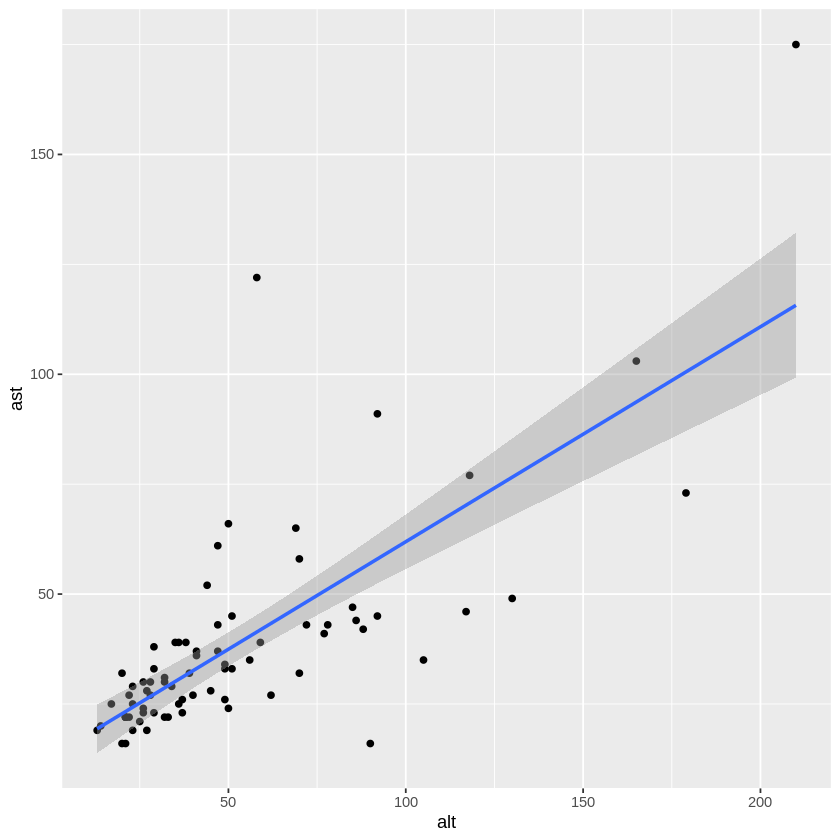

In [19]:
ggplot(nafldDataset, aes(x=alt, y=ast)) + geom_point() + geom_smooth(method=lm)

Plots created with ```ggplot2``` can further be refined (e.g. axis labels and axis limits can be changed, legend can be added). You can find a very useful and succint overview of possibilities on this [cheat sheet](https://github.com/rstudio/cheatsheets/blob/master/data-visualization-2.1.pdf).  

* **Q3.5:** Using the FIB-4 score values determined in the previous question, create a boxplot showing the distribution of FIB-4 scores across fibrosis stages. Label the x axis as "Fibrosis stage" and the y axis as "FIB-4 score".

### Linear regression and Anova 

We've done _simple_ linear regression above and it's relatively easy to understand what is going on. 
Let's make it more complicated and look for explaining one thing as a function of others -- say, for example, let's try to "explain" ALT by including age as well as AST: 

In [34]:
colnames(nafldDataset)
summary(lm(alt~age+ast, data=nafldDataset))

[1] "country"     "continent"   "centre"      "gender"      "age"        
 [6] "height"      "weight"      "bmi"         "waist_circ"  "dm2"        
[11] "plt"         "alt"         "ast"         "ggt"         "hdl_chol"   
[16] "tg"          "fglu"        "bx_date"     "bx_length"   "bx_fib"     
[21] "bx_nas"      "te_date"     "bx_te_days"  "probe"       "valid_shots"
[26] "lsm"         "iqr"         "iqr_median"  "success"


Call:
lm(formula = alt ~ age + ast, data = nafldDataset)

Residuals:
    Min      1Q  Median      3Q     Max 
-66.018 -14.273  -2.874  11.021  61.798 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  77.3527    14.1713   5.458 6.29e-07 ***
age          -1.1810     0.2293  -5.150 2.13e-06 ***
ast           0.9827     0.1060   9.269 5.83e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 22.05 on 73 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.673,	Adjusted R-squared:  0.6641 
F-statistic: 75.13 on 2 and 73 DF,  p-value: < 2.2e-16


Ahh, this is interesting! So, it looks like ALT decreases significantly with age. Let's try to plot this, and have a look: 

Warning message:
“Removed 1 rows containing missing values (geom_point).”


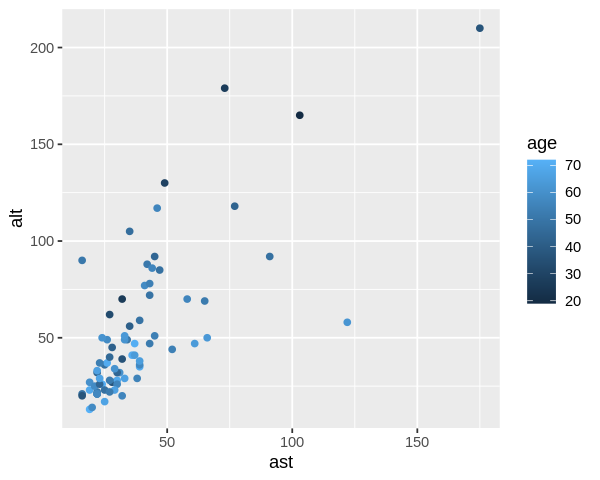

In [38]:
ggplot(data=nafldDataset) + geom_point(aes(x=ast,y=alt,color=age))

Interesting. But also a bit unclear -- we've got a point cloud in 3D and w'ere looking at different slices of it. Let's look at it "rotated" by 90º: 

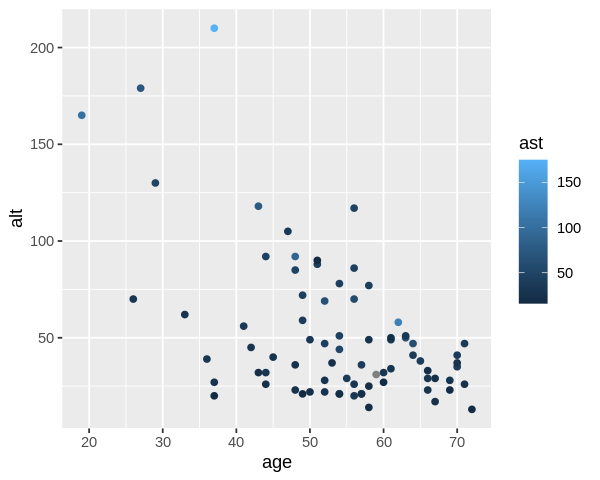

In [39]:
ggplot(data=nafldDataset) + geom_point(aes(x=age,y=alt,color=ast))

So, ALT _definitely_ drops with age, and increases as AST does. This is a good example of a multivariate database with a lot of complex relationships behind it. 

How does this relate to Anova? Well, the full, detailed explanation of how Anova works is really quite long (and if you're interested in finding out, here is a great [link](https://dzchilds.github.io/stats-for-bio/introduction-to-one-way-anova.html) to an e-book in R that goes through a detailed, understandable explanation of what's really going on behind the scenes. 

If you want to ask the question "if I've got multiple variables, does the thing I'm interested in change as I vary them?" then this is a great way to do it. And as ever, in R, it's a built-in function that does the heavy lifting: 

In [40]:
anova(lm(alt~age+ast, data=nafldDataset))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
age,1,31295.23,31295.234,64.34913,1.281526e-11
ast,1,41786.31,41786.312,85.92084,5.830743e-14
Residuals,73,35502.45,486.335,NA,NA


This tells us that both age and AST have a significant effect. And the $p$-values are different to the $t$-test p-values that they're significantly different to zero -- but that's because we've really "hidden" the mathematical detail here, to quite some extent. 

One thing I should say is that it's possible with more than two variables to have _interactions_ between them. For example, let's say I measure two things: gender, and a blood biomarker I'm interested in, $x$, in patients. I give them either a drug or a control pill, and measure an output (another blood biomarker, $y$, let's say). Now, the regression I may want to do here is `y ~ x + gender + drug`. If the drug has an effect, we'd expect the regression term for it to be nonzero and an anova to be significant. But what happens if the drug turns out to only work condtionally on another variable -- say it cures women and does nothing to men? Or it helps if $x$ is less than a concentration, but hinders if it is above it? 

This is an example of an interaction. They're complex, and often difficult to understand -- because the change that a factor has, whether it's positive or negative, depends on the value of other things. Arguably it changes how you interpret the results -- for that reason, many people suggest only including them in a model if they are significant, and looking for them first to see if they are there. 

Mathematically, this layering of results results in a product of terms in a linear regression; in R searching for an interaction is as simple as typing `*` rather than `+` and the result is told to you as a "`:`" in the anova table, indicating the interaction and its p-value.  

For example: 

In [41]:
anova(lm(alt~age*ast, data=nafldDataset))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
age,1,31295.234,31295.234,73.67016,1.249887e-12
ast,1,41786.312,41786.312,98.36655,4.178022e-15
age:ast,1,4916.707,4916.707,11.57411,1.095054e-03
Residuals,72,30585.747,424.802,NA,NA


* **Q3.6:** Try and understand what this means (hint: plotting subsets of data might help, as might the resources linked above, specifically [this](https://dzchilds.github.io/stats-for-bio/two-way-anova-in-r.html#interpreting-the-results-1) page)

#  Neatly reporting your findings
Data analysis and plotting are essential parts of evaluating the results of an experiment or set of experiments. However, reporting those results is equally important and R can help with that too! Reports can be generated from R directly, using various packages - and the results can be saved in HTML, LaTeX, LaTeX beamer, DocBook XML, RTF and even Word docx formats.  This is occasionally very handy! 


In this section we will use the __knitr__ and __markdown__ packages to generate an HTML and a docx version of a report that will contain a subset of our NAFLD patient data set, some statistical analysis, plots and text to describe our findings. We will use the markdown convention to write our report in R. Markdown is a simplified document format, which allows to encode formatting (e.g. lists, bold face, tables, links) to be defined in a text-only fashion. Markdown documents are then turned into HTML, XML, LaTeX or PDF documents in which all text appears nicely formatted.

All the code presented in this section (unless specified otherwise) will need to be saved in a file with the .Rmd extension.  

The header of our report file will define the title, author and document type we want to get in the end:  

```
---
title: "Brief report on NAFLD patients"
author: "Ferenc Mozes"
date: "17/01/2021"
output: word_document
---
```

We will start filling up the report by first inserting our data table. Since we haven't used all columns from the NAFLD data frame, we will restrict ourselves to including only the most relevant ones. Instead of manually copying data from the data frame, we will use __knitr__'s kable function to generate a markdown table and insert it into our report:

```
knitr::kable(nafldDataset[c("alt", "ast", "tg", "bmi", "lsm", "probe")], 
             format="markdown", 
             caption="NAFLD patient data. ALT, AST, BMI and triglycerides are listed in addition 
                      to liver stiffness measurements and FibroScan probe type.",
             col.names=c("ALT (IU/l)", "AST (IU/l)", "TG (mg/dl)", "BMI (kg/m2)", "LSM (kPa)","Probe type"),
             align="cccccc")
```

Then we will include the output of the correlation analysis (between BMI and triglycerides) and the results of the linear model (between AST and ALT).  

```
```{r corr}
cor.test(nafldDataset$bmi[!is.na(nafldDataset$bmi) & !is.na(nafldDataset$tg)], 
    nafldDataset$tg[!is.na(nafldDataset$bmi) & !is.na(nafldDataset$tg)])
``````

```
```{r lm}
regressionRes <- lm(ast~alt, data=nafldDataset)
summary(regressionRes)
``````

Note how code chunks are preceded by ```{r label}```. This instructs the markdown translator to evaluate the code chunk as if it were a piece of R code (which it is!). It is also noteworthy that all code chunks need to be enclosed between triple backticks (or graves).  
We will finally insert a scatter plot visualising the linear relationship between AST and ALT.

```
```{r lm_fig, fig.cap = "The relationship between AST and ALT in morbidly obese patients with NAFLD"}
ggplot(nafldDataset, aes(x=alt, y=ast)) + geom_point() + geom_smooth(method=lm)
``````

You can of course (and are encouraged to!) add explanations and interpretations of the statistical analysis you're doing, as a large part of reporting also consists of pointing out relationship and discussing findings. But for our example, the markdown code presented so far should be enough to give you an idea how reports can be generated.  
The final step is to actually export the markdown document into a formatted document:

In [74]:
library(rmarkdown)
# Export into a Word (docx) document
render("nafld_report.Rmd", output_format = "word_document")
# Export into a PDF document (via LaTeX) - may not work in the Jupyter notebook
# render("nafld_report.Rmd", output_format = "pdf_document")
# Export into a HTML web page
render("nafld_report.Rmd", output_format = "html_document")




processing file: nafld_report.Rmd


  |......                                                           |  10%
  ordinary text without R code

  |.............                                                    |  20%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................                                             |  30%
  ordinary text without R code

  |..........................                                       |  40%
label: table (with options) 
List of 1
 $ echo: logi FALSE

  |................................                                 |  50%
  ordinary text without R code

  |.......................................                          |  60%
label: corr
  |..............................................                   |  70%
  ordinary text without R code

  |....................................................             |  80%
label: lm
  |..........................................................       |  90%
  ordinary text without R code

  |.................

output file: nafld_report.knit.md



/Users/mferenc/Documents/anaconda/anaconda3/envs/Rtuts/bin/pandoc +RTS -K512m -RTS nafld_report.utf8.md --to docx --from markdown+autolink_bare_uris+ascii_identifiers+tex_math_single_backslash+smart --output nafld_report.docx --highlight-style tango 



Output created: nafld_report.docx


processing file: nafld_report.Rmd


  |......                                                           |  10%
  ordinary text without R code

  |.............                                                    |  20%
label: setup (with options) 
List of 1
 $ include: logi FALSE

  |....................                                             |  30%
  ordinary text without R code

  |..........................                                       |  40%
label: table (with options) 
List of 1
 $ echo: logi FALSE

  |................................                                 |  50%
  ordinary text without R code

  |.......................................                          |  60%
label: corr
  |..............................................                   |  70%
  ordinary text without R code

  |....................................................             |  80%
label: lm
  |..........................................................       |  90%
  ordinary text without R code

  |.................

output file: nafld_report.knit.md



/Users/mferenc/Documents/anaconda/anaconda3/envs/Rtuts/bin/pandoc +RTS -K512m -RTS nafld_report.utf8.md --to html4 --from markdown+autolink_bare_uris+ascii_identifiers+tex_math_single_backslash+smart --output nafld_report.html --email-obfuscation none --self-contained --standalone --section-divs --template /Users/mferenc/Documents/anaconda/anaconda3/envs/Rtuts/lib/R/library/rmarkdown/rmd/h/default.html --no-highlight --variable highlightjs=1 --variable 'theme:bootstrap' --include-in-header /var/folders/ky/fhnqjvsd6k90qqxy48cf8vsc0000gn/T//RtmpqPCqmT/rmarkdown-str5f551f618f1f.html --mathjax --variable 'mathjax-url:https://mathjax.rstudio.com/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML' 



Output created: nafld_report.html
